In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',1000)
import os
from glob import iglob

In [28]:
# Load all structural p-values across both analyses
df = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-06-21/modbase_cosmic/recurrence_K_summary.txt",delimiter='\t')
df = df.drop_duplicates(["structid","chain"])
mod2unp = pd.read_csv("modbase2unpac.txt",delimiter='\t')
df  = df.merge(mod2unp,left_on="structid",right_on="modelid")

In [29]:
print "Number of structures evaluated:"
print len(df)
print "Number of variants evluated:"
print "%.0f"%np.sum(df["N"])

from qvalue import estimate
THRESH = 0.1

df.ix[~df[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(df.ix[~df[ "Kp"].isnull(), "Kp"].values)

print "\nProteins passing an FDR of %.0f%% for the unweighted analysis"%(THRESH*100)
print "Structures:   %4d"%( df['Kq']<THRESH).sum()
print "    Clustered: %4d"%((df['Kq']<THRESH) & (df["Kz"]>0)).sum()
print "    Dispersed: %4d"%((df['Kq']<THRESH) & (df["Kz"]<0)).sum()
print "Proteins:     %4d"%len(df[df['Kq']<THRESH].drop_duplicates("unp"))
print "    Clustered: %4d"%len(df[(df['Kq']<THRESH) & (df["Kz"]>0)].drop_duplicates("unp"))
print "    Dispersed: %4d"%len(df[(df['Kq']<THRESH) & (df["Kz"]<0)].drop_duplicates("unp"))

df.ix[~df["wKp"].isnull(),"wKq"], wK_lam, wK_pi = estimate(df.ix[~df["wKp"].isnull(),"wKp"].values)

print "\nProteins passing an FDR of %.0f%% for the weighted analysis"%(THRESH*100)
print "Structures:   %4d"%( df['wKq']<THRESH).sum()
print "    Clustered: %4d"%((df['wKq']<THRESH) & (df["wKz"]>0)).sum()
print "    Dispersed: %4d"%((df['wKq']<THRESH) & (df["wKz"]<0)).sum()
print "Proteins:     %4d"%len(df[df['wKq']<THRESH].drop_duplicates("unp"))
print "    Clustered: %4d"%len(df[(df['wKq']<THRESH) & (df["wKz"]>0)].drop_duplicates("unp"))
print "    Dispersed: %4d"%len(df[(df['wKq']<THRESH) & (df["wKz"]<0)].drop_duplicates("unp"))

Number of structures evaluated:
96189
Number of variants evluated:
2390300

Proteins passing an FDR of 10% for the unweighted analysis
Significant:     77
    Clustered:   71
    Dispersed:    6
Proteins:       43
    Clustered:   39
    Dispersed:    4

Proteins passing an FDR of 10% for the weighted analysis
Structures:      0
    Clustered:    0
    Dispersed:    0
Proteins:        0
    Clustered:    0
    Dispersed:    0


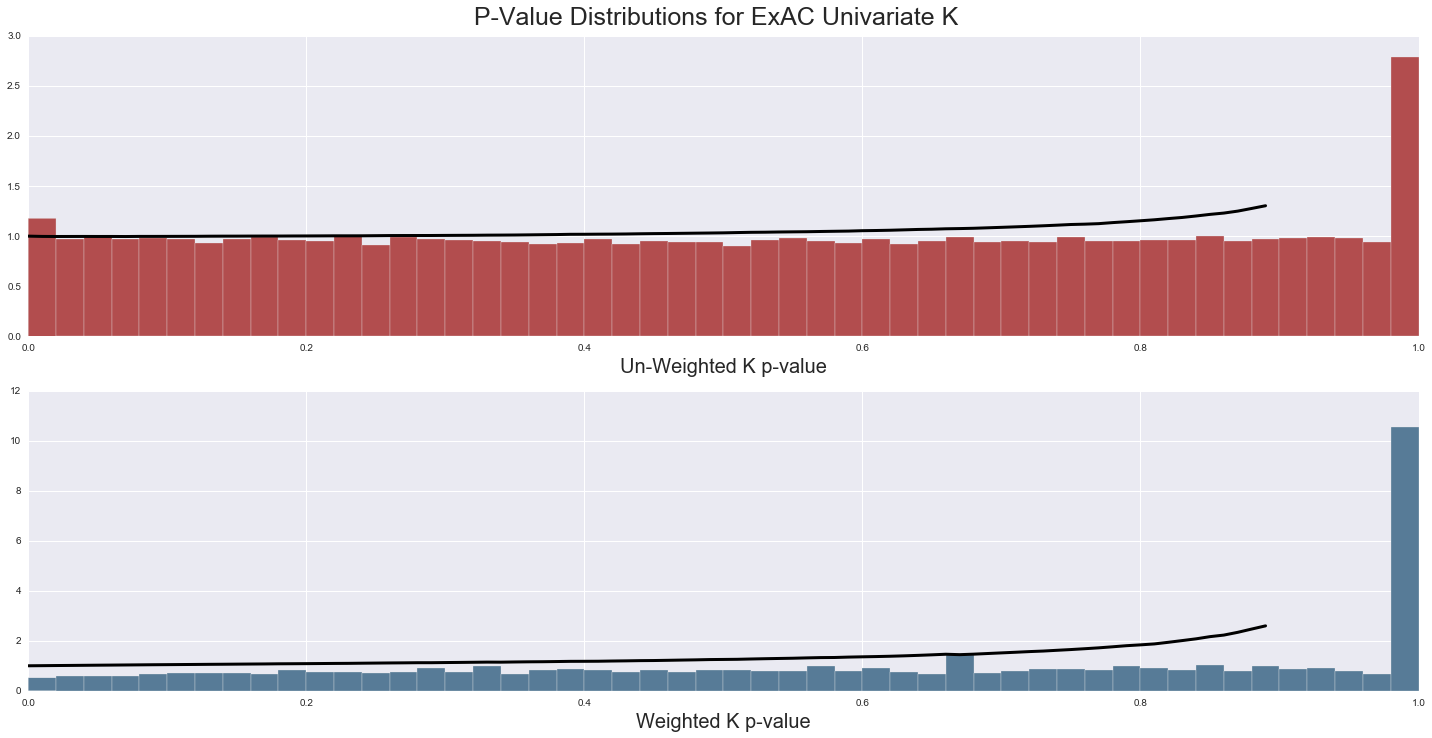

In [12]:
# P-Value Distributions
pal = list(sns.color_palette("Set1", n_colors=2, desat=.5))
fig,ax = plt.subplots(2,1,figsize=(20,10))
plt.suptitle("P-Value Distributions for ExAC Univariate K",fontsize=25,y=1.02)
ax[0].set_xlabel("Un-Weighted K p-value",fontsize=20)
ax[0].hist(df["Kp"],bins=np.arange(0,1.02,0.02),color=pal[0],normed=True)
ax[0].plot(K_lam,K_pi,lw=3,c='black')
ax[1].set_xlabel("Weighted K p-value",fontsize=20)
ax[1].hist(df["wKp"],bins=np.arange(0,1.02,0.02),color=pal[1],normed=True)
ax[1].plot(wK_lam,wK_pi,lw=3,c='black')
plt.tight_layout()
plt.show()

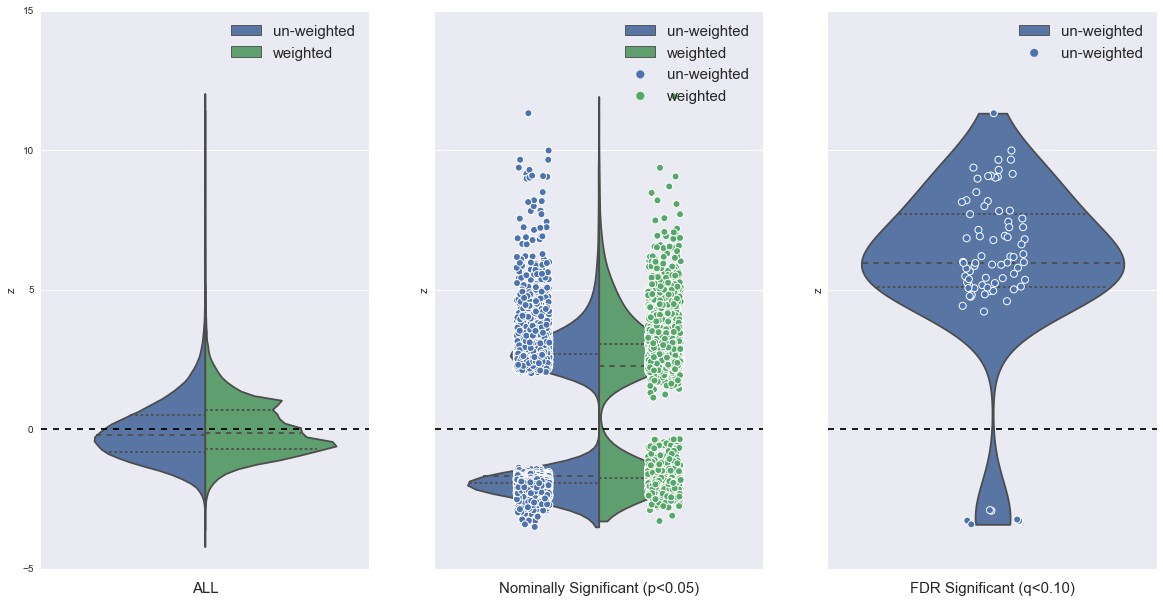

In [43]:
dfu = pd.DataFrame(df[["Kp","Kz"]].values,columns=["p","z"])
dfu['q'] = estimate(dfu["p"].values)[0]
dfu["w"] = "un-weighted"
dfw = pd.DataFrame(df[["wKp","wKz"]].values,columns=["p","z"])
dfw['w'] = "weighted"
dfw.ix[~dfw['p'].isnull(),'q'] = estimate(dfw.ix[~dfw['p'].isnull(),"p"].values)[0]
dfv = pd.concat((dfu,dfw))
dfv['dummy'] = ""

fig,ax = plt.subplots(1,3,figsize=(20,10),sharey=True)
sns.violinplot(x='dummy',y="z",hue='w',data=dfv,ax=ax[0],cut=1,orient='v',split=True,inner='quart')
dfv1 = dfv[dfv["p"]<0.05]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=True,jitter=True,s=7,lw=1,edgecolor='white')
dfv1 = dfv[dfv["q"]<THRESH]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=True,jitter=True,s=7,lw=1,edgecolor='white')
ax[0].set_xlabel("ALL",fontsize=15)
ax[1].set_xlabel("Nominally Significant (p<0.05)",fontsize=15)
ax[2].set_xlabel("FDR Significant (q<%.2f)"%THRESH,fontsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
plt.ylim([-5,15])
ax[0].axhline(0.,ls='dashed',c='black')
ax[1].axhline(0.,ls='dashed',c='black')
ax[2].axhline(0.,ls='dashed',c='black')
plt.show()

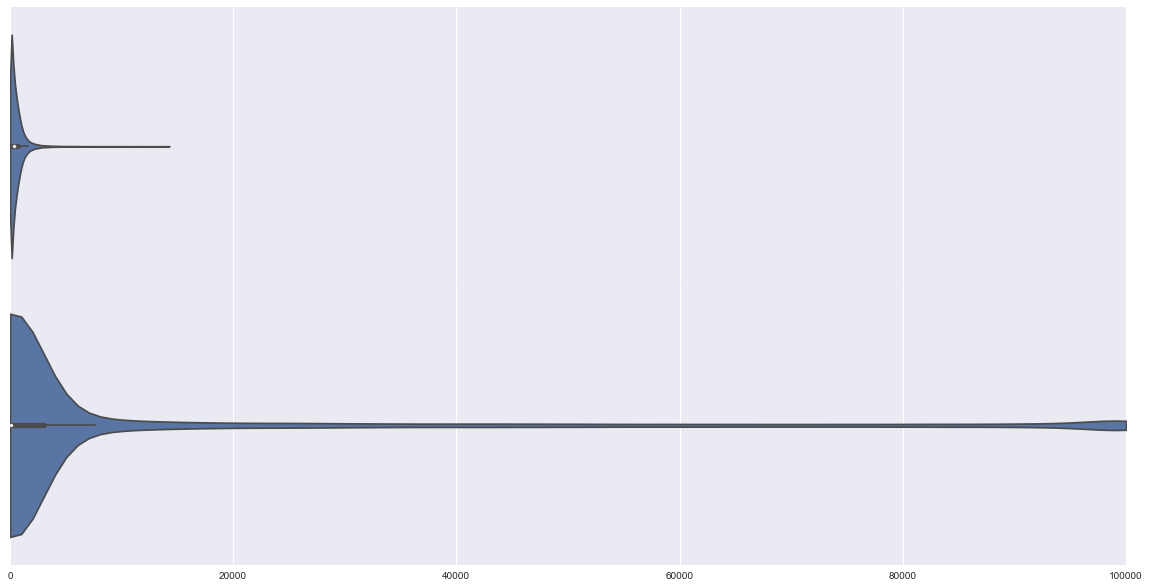

In [44]:
# Despite 100k permutations, very few structures
# observe anywhere near that many unique values
fig,ax = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
sns.violinplot(df['P'].values, cut=0,ax=ax[0])
sns.violinplot(df['wP'].values,cut=0,ax=ax[1])
ax[0].set_xlim([0,100000])
ax[1].set_xlim([0,100000])
plt.show()

In [45]:
print "Un-Weighted: FDR-Significantly Clustered Proteins"
print df.ix[(df["Kq"]<0.1) & (df["Kz"]>0),["structid","chain","Kz","Kp","Kq"]]

Un-Weighted: FDR-Significantly Clustered Proteins
                 structid chain         Kz       Kp        Kq
4333   ENSP00000448916_10     A   7.553872  0.00002  0.040074
4845    ENSP00000350446_9     A   9.053364  0.00004  0.061065
8212    ENSP00000351617_1     A   5.857060  0.00004  0.061065
8562    ENSP00000336861_1     A   5.905822  0.00002  0.040074
22802   ENSP00000364887_1     A   9.663585  0.00002  0.040074
26365   ENSP00000364010_2     A   5.999486  0.00008  0.099925
32482   ENSP00000381167_3     A   9.993069  0.00002  0.040074
34394   ENSP00000381167_2     A   9.379315  0.00002  0.040074
36939   ENSP00000373608_4     A   5.659418  0.00002  0.040074
39054  ENSP00000401306_17     A   9.154717  0.00002  0.040074
39861   ENSP00000340610_4     A   7.439969  0.00002  0.040074
47514   ENSP00000462950_1     A   5.486867  0.00008  0.099925
47635   ENSP00000453015_1     A   4.219650  0.00008  0.099925
48185   ENSP00000368854_4     A   4.749668  0.00008  0.099925
48328   ENSP00000376

In [46]:
print "Un-Weighted: FDR-Significantly Dispersed Proteins"
print df.ix[(df["Kq"]<0.1) & (df["Kz"]<0),["structid","chain","Kz","Kp","Kq"]]

Un-Weighted: FDR-Significantly Dispersed Proteins
                structid chain        Kz       Kp        Kq
20676  ENSP00000356048_1     A -2.918205  0.00002  0.040074
32674  ENSP00000472619_3     A -2.896624  0.00004  0.061065
36613  ENSP00000404185_2     A -3.281139  0.00002  0.040074
82938  ENSP00000339549_1     A -3.272599  0.00008  0.099925
87351  ENSP00000453390_1     A -3.233679  0.00006  0.084863
94065  ENSP00000296137_2     A -3.406590  0.00006  0.084863
